In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using device: {device}")

Using device: mps


In [4]:
# Définition des transformations
tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [5]:
# Chargement du dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("../data/raw", train=True, download=True, transform=tf),
    batch_size=64, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("../data/raw", train=False, download=True, transform=tf),
    batch_size=64, shuffle=True
)

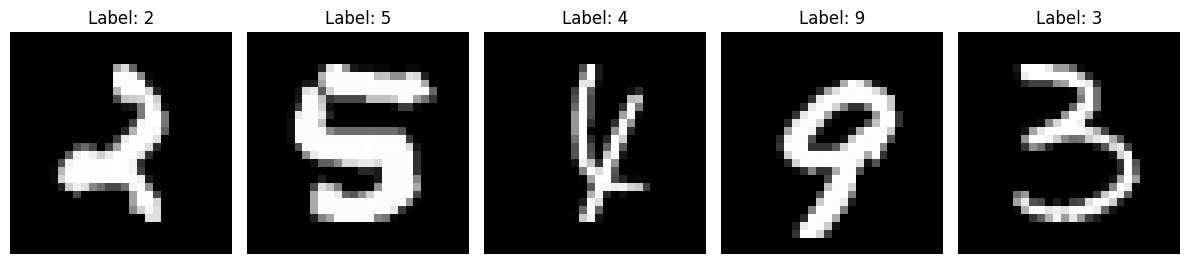

In [6]:
# Affichage des 5 premières images
batch = next(iter(train_loader))
x = batch[0][:5]
y = batch[1][:5]

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    axes[i].imshow(x[i][0], cmap="gray")
    axes[i].set_title(f"Label: {y[i].item()}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

In [8]:
class ConvNet(nn.Module):
    def __init__(self, input_size, n_kernels, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, n_kernels, kernel_size=5),   # 28x28 -> 24x24
            nn.ReLU(),
            nn.MaxPool2d(2),                          # 24x24 -> 12x12
            nn.Conv2d(n_kernels, n_kernels, kernel_size=5),  # 12x12 -> 8x8
            nn.ReLU(),
            nn.MaxPool2d(2),                          # 8x8 -> 4x4
            nn.Flatten(),                             # -> n_kernels * 4 * 4
            nn.Linear(n_kernels * 4 * 4, 50),
            nn.Linear(50, output_size)
        )

    def forward(self, x):
        return self.net(x)

In [9]:
input_size = 28 * 28
n_kernels = 6
output_size = 10

model = ConvNet(input_size, n_kernels, output_size).to(device)
print(f"Nombre de paramètres : {sum(p.numel() for p in model.parameters())/1e3:.3f}K")


Nombre de paramètres : 6.422K


In [10]:
def train(model, perm=torch.arange(0, 784).long(), n_epoch=1):
    model.train()  # met le modèle en mode entraînement
    optimizer = torch.optim.AdamW(model.parameters())

    for epoch in range(n_epoch):
        for step, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            # Appliquer permutation circulaire si besoin
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)

            optimizer.zero_grad()
            logits = model(data)
            loss = F.cross_entropy(logits, target)
            loss.backward()
            optimizer.step()

            if step % 100 == 0:
                print(f"epoch={epoch}, step={step}: train loss={loss.item():.4f}")


In [11]:
train(model)

epoch=0, step=0: train loss=2.3177
epoch=0, step=100: train loss=0.2790
epoch=0, step=200: train loss=0.3607
epoch=0, step=300: train loss=0.4194
epoch=0, step=400: train loss=0.2407
epoch=0, step=500: train loss=0.0702
epoch=0, step=600: train loss=0.0878
epoch=0, step=700: train loss=0.0845
epoch=0, step=800: train loss=0.2575
epoch=0, step=900: train loss=0.2101


In [12]:
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()  # mode évaluation
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Appliquer la permutation
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)

            logits = model(data)
            test_loss += F.cross_entropy(logits, target, reduction='sum').item()

            pred = torch.argmax(logits, dim=1)
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    print(f"test loss={test_loss:.4f}, accuracy={accuracy:.4f}")


In [13]:
test(model)

test loss=0.0994, accuracy=0.9693


In [14]:
def main():
    input_size = 28 * 28
    output_size = 10
    n_kernels = 6

    model = ConvNet(input_size, n_kernels, output_size).to(device)
    print(f"Parameters={sum(p.numel() for p in model.parameters())/1e3:.3f}K")

    train(model)
    test(model)


In [15]:
main()

Parameters=6.422K
epoch=0, step=0: train loss=2.3314
epoch=0, step=100: train loss=0.3924
epoch=0, step=200: train loss=0.4221
epoch=0, step=300: train loss=0.2222
epoch=0, step=400: train loss=0.1408
epoch=0, step=500: train loss=0.2932
epoch=0, step=600: train loss=0.2213
epoch=0, step=700: train loss=0.0491
epoch=0, step=800: train loss=0.0966
epoch=0, step=900: train loss=0.1820
test loss=0.1004, accuracy=0.9693


In [16]:
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),  # aplatissement des images
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size)
        )

    def forward(self, x):
        return self.net(x)


In [17]:
input_size = 28 * 28
output_size = 10
n_hidden = 8

mlp = MLP(input_size, n_hidden, output_size).to(device)
print(f"Parameters={sum(p.numel() for p in mlp.parameters())/1e3:.3f}K")

train(mlp)
test(mlp)

Parameters=6.442K
epoch=0, step=0: train loss=2.3548
epoch=0, step=100: train loss=1.3719
epoch=0, step=200: train loss=0.6701
epoch=0, step=300: train loss=0.6226
epoch=0, step=400: train loss=0.6928
epoch=0, step=500: train loss=0.6893
epoch=0, step=600: train loss=0.5063
epoch=0, step=700: train loss=0.3925
epoch=0, step=800: train loss=0.2446
epoch=0, step=900: train loss=0.4941
test loss=0.4430, accuracy=0.8722


### 📊 Comparaison CNN vs MLP sur MNIST

| Critère              | CNN (~6.42K params) | MLP (~6.44K params) |
|----------------------|---------------------|----------------------|
| **Perte (test)**     | 0.0994              | 0.4430               |
| **Précision (test)** | 96.93 %             | 87.22 %              |

---

### 🧠 Analyse simple

- Le **CNN** est **plus efficace** que le **MLP** pour reconnaître des chiffres sur des images.
- Cela s'explique par le fait que :
  - Le **CNN** peut repérer des formes locales (traits, coins, courbes) car il tient compte de la structure de l’image (grâce aux couches de convolution et de pooling).
  - Le **MLP**, lui, traite chaque pixel séparément, sans comprendre qu’un pixel est proche d’un autre. Il apprend donc moins bien sur des images.

---

### ✅ Conclusion

Même avec presque le **même nombre de paramètres**, le **CNN est beaucoup plus performant** que le MLP sur ce type de données.

Il est donc **mieux adapté pour analyser des images**, car il sait capter la **forme et la position des motifs**, ce que ne fait pas un MLP.

In [18]:
perm = torch.randperm(784)

In [19]:
convnet_perm = ConvNet(input_size, n_kernels, output_size).to(device)
print(f"[CNN permuté] Parameters={sum(p.numel() for p in convnet_perm.parameters())/1e3:.3f}K")

train(convnet_perm, perm=perm)
test(convnet_perm, perm=perm)

[CNN permuté] Parameters=6.422K
epoch=0, step=0: train loss=2.3049
epoch=0, step=100: train loss=1.2912
epoch=0, step=200: train loss=0.6717
epoch=0, step=300: train loss=0.5261
epoch=0, step=400: train loss=0.7551
epoch=0, step=500: train loss=0.5791
epoch=0, step=600: train loss=0.3367
epoch=0, step=700: train loss=0.5788
epoch=0, step=800: train loss=0.5605
epoch=0, step=900: train loss=0.5001
test loss=0.3948, accuracy=0.8805


In [20]:
mlp_perm = MLP(input_size, n_hidden, output_size).to(device)
print(f"[MLP permuté] Parameters={sum(p.numel() for p in mlp_perm.parameters())/1e3:.3f}K")

train(mlp_perm, perm=perm)
test(mlp_perm, perm=perm)


[MLP permuté] Parameters=6.442K
epoch=0, step=0: train loss=2.3965
epoch=0, step=100: train loss=1.4215
epoch=0, step=200: train loss=0.9672
epoch=0, step=300: train loss=0.7979
epoch=0, step=400: train loss=0.5457
epoch=0, step=500: train loss=0.7244
epoch=0, step=600: train loss=0.6537
epoch=0, step=700: train loss=0.7273
epoch=0, step=800: train loss=0.5054
epoch=0, step=900: train loss=0.5484
test loss=0.4516, accuracy=0.8692


In [ ]:
### 🌀 Effet d'une permutation aléatoire sur les performances

> Nous avons appliqué une permutation aléatoire des pixels sur les images MNIST, et réentraîné les deux modèles (CNN & MLP).

#### 📊 Résultats comparés

| Modèle        | Accuracy sans permutation | Accuracy avec permutation |
|---------------|---------------------------|----------------------------|
| **CNN**       | 96.93 %                   | 88.05 %                   |
| **MLP**       | 87.22 %                   | 86.92 %                   |

#### 🧠 Analyse

- Le **CNN** perd **près de 9 points** d’accuracy, car la permutation **détruit la structure spatiale** des images.
- Le **MLP**, en revanche, n’est **presque pas affecté**, car il **n’exploite pas la disposition spatiale des pixels**.
- Cela confirme que les **CNN sont très dépendants de la structure locale** des images (ce qui est une force quand elle est présente), alors que les **MLP traitent chaque pixel indépendamment**.

#### ✅ Conclusion

- La permutation des pixels permet de montrer que le **CNN utilise réellement la structure spatiale** pour apprendre.
- Le **MLP**, lui, est déjà insensible à cette structure, ce qui explique pourquoi sa performance reste stable… mais inférieure à celle d’un CNN non permuté.


In [22]:
# Sauvegarde du modèle CNN original (non permuté)
torch.save(model.state_dict(), "../model/mnist-0.0.1.pt")